# Discrete frame-level variational autoenoders

Ryan Eloff, ryan.peter.eloff@gmail.com, February 2019.

Based on code from the following paper:
- H. Kamper, "Truly unsupervised acoustic word embeddings using weak top-down constraints in encoder-decoder models," *arXiv preprint arXiv:1811.00403*, 2018. [[arXiv](https://arxiv.org/abs/1811.00403)][[code](https://github.com/kamperh/recipe_bucktsong_awe)]

### Preamble

Re-load all modules before executing Python cells, and use the matplotlib 'inline' backend:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [3]:
import os
import sys

In [4]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [5]:
sys.path.append(os.path.join("..", "src"))
sys.path.append(os.path.join("..", "embeddings"))

In [23]:
from constants import TF_FLOAT_DTYPE
from constants import TF_INT_DTYPE
from constants import NP_INT_DTYPE
from tf_base.models import ae
from tf_base.models import rnn
from tf_base import training
from tf_base import vis
from utils import batching

In [7]:
output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Load data

In [8]:
# TODO(rpeloff) buckeye from zerospeech2015, and/or english data from zerospeech2019? Extracted on sheldon?
feats_dir = os.path.join("..", "features")
feats = "fbank"

train_npz = np.load(os.path.join(feats_dir, feats, "english", "train.npz"))
test_npz = np.load(os.path.join(feats_dir, feats, "english", "test.npz"))

In [9]:
def read_npz(npz, quiet=True):
    keys = []
    x_data = []
    x_lengths = []
    speakers = []
    num_data = 0
    for utterance_key in sorted(npz.keys()):
        # process next utterance
        data = npz[utterance_key]
        length = data.shape[0]
        speaker = utterance_key.split('_')[0][:3]
        # store utterance data
        x_data.append(data)
        x_lengths.append(length)
        speakers.append(speaker)
        num_data += 1
    if not quiet:
        print('No. of utterances in npz:', num_data)
    return keys, x_data, x_lengths, speakers

In [10]:
train_keys, train_x_data, train_x_lengths, train_speakers = read_npz(train_npz, quiet=False)
test_keys, test_x_data, test_x_lengths, test_speakers = read_npz(test_npz, quiet=False)

No. of utterances in npz: 44136
No. of utterances in npz: 13994


In [11]:
print("E.g. item shape:", train_x_data[0].shape)

E.g. item shape: (147, 45)


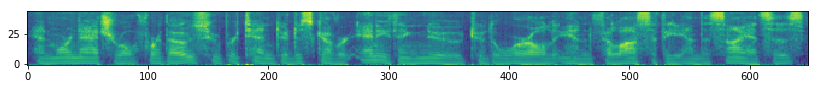

In [12]:
plt.figure(figsize=(14, 8))
plt.imshow(train_x_data[14473].T, origin="bottom");

In [13]:
# Convert speakers to integers
all_speakers = set(train_speakers).union(set(test_speakers))
speaker_to_id = {}  # speaker->id lookup
id_to_speaker = {}  # id->speaker lookup
for index, speaker in enumerate(sorted(list(all_speakers))):
    speaker_to_id[speaker] = index
    id_to_speaker[index] = speaker
    
# Get train speaker ids
train_speaker_id = []
for speaker in train_speakers:
    train_speaker_id.append(speaker_to_id[speaker])
train_speaker_id = np.array(train_speaker_id, dtype=NP_INT_DTYPE)

# Get test speaker ids
test_speaker_id = []
for speaker in test_speakers:
    test_speaker_id.append(speaker_to_id[speaker])
test_speaker_id = np.array(test_speaker_id, dtype=NP_INT_DTYPE)

speaker_gender_dict = {
    # ...?
}

Largest x length: 1400 frames
2 std deviations (95%): 395 frames
Outliers above max_length=600: 0.387 %


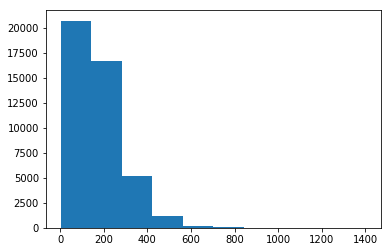

In [14]:
max_length = 600
num_outliers = 0
two_std = np.mean(train_x_lengths) + 2*np.std(train_x_lengths)
for x_length in train_x_lengths:
    num_outliers += 1 if x_length > max_length else 0

# Display train_x_length stats
plt.hist(train_x_lengths)
print("Largest x length: {:d} frames".format(np.max(train_x_lengths)))
print("2 std deviations (95%): {:d} frames".format(int(round(two_std))))
print("Outliers above max_length={:d}: {:.3f} %".format(max_length, num_outliers/len(train_x_lengths)*100))

In [15]:
# Truncate and limit dimensionality
dim_frame_feats = train_x_data[0].shape[-1]

def truncate_segments(max_length, x_data, x_lengths, dim_frame_feats=13):    
    for i, seq in enumerate(x_data):
        x_data[i] = x_data[i][:max_length, :dim_frame_feats]
        x_lengths[i] = min(x_lengths[i], max_length)

truncate_segments(max_length, train_x_data, train_x_lengths, dim_frame_feats)
truncate_segments(max_length, test_x_data, test_x_lengths, dim_frame_feats)

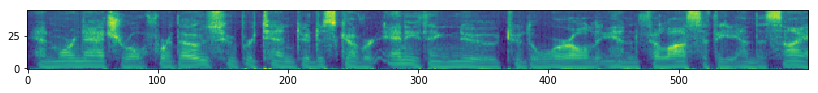

In [16]:
plt.figure(figsize=(14, 8))
plt.imshow(train_x_data[14473].T, origin="bottom");

### Many-to-many sequence-to-sequence model with frame-level latent transformation (autoencoder)

In [27]:
# TODO(rpeloff): should rename this to `def build_the_thing_with_to_many_words(...)`
def build_multi_layer_many_to_many_with_latent(
        x_input, x_lengths, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
        rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None):
    """Build a multi-layer many-to-many sequence-to-sequence model with per-frame latent layers.
    
    Note: The decoders output is processed by a linear transformation such that the final
    output dimensionality matches that of the input `x_input`. 
    
    TODO(rpeloff): function doc
    
    `decoder_conditioning`: 
        Optionally condition the decoder on the concatenation of the latent representation and this tensor.
    """
    max_length = tf.math.reduce_max(x_lengths)  # compute maximum along the lengths tensor
    x_tensor = tf.convert_to_tensor(x_input)
    dim_features = x_tensor.get_shape().as_list()[-1]  # get input features dimensionality

    # Multi-layer RNN encoder
    # -----------------------
    encoder_output, encoder_states = rnn.build_multi_layer_rnn(
        x_tensor, x_lengths, encoder_hidden_units, rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_encoder")
    
    # Latent transformation
    # ---------------------
    encoder_output_flattened = tf.reshape(encoder_output, [-1, encoder_hidden_units[-1]])
    latent_output = latent_transform(encoder_output_flattened, **latent_kwargs)
    recon_output = latent_output["y"]  # latent reconstruction output
    
    dim_recon_output = recon_output.get_shape().as_list()[-1]  # get latent layer feature dimensionality
    recon_output = tf.reshape(recon_output, [-1, max_length, dim_recon_output])  # reshaped (n_data, frames, feats)
    
    # Additional decoder conditioning
    # -------------------------------
    if decoder_conditioning is not None:
        dim_conditioning_tensor = decoder_conditioning.get_shape().as_list()[-1]
        tiled_conditioning = tf.reshape(  # tile conditioning tensor to max_length
            tf.tile(decoder_conditioning, [1, max_length]), [-1, max_length, dim_conditioning_tensor])
        # TODO(rpeloff): should dim_conditioning_tensor == dim_recon_output?
        decoder_input = tf.concat([recon_output, tiled_conditioning], axis=-1)
    else:
        decoder_input = recon_output
        
    # Multi-layer RNN decoder
    # -----------------------
    decoder_output, decoder_states = rnn.build_multi_layer_rnn(
        decoder_input, x_lengths, decoder_hidden_units, rnn_cell, rnn_cell_kwargs, keep_prob, scope="rnn_decoder")
    
    # Final linear transformation
    # ---------------------------
    with tf.variable_scope("rnn_decoder/linear_output"):
        mask = tf.sign(tf.reduce_max(tf.abs(decoder_output), 2))  # get zero mask from padding
        decoder_output = tf.reshape(decoder_output, [-1, decoder_hidden_units[-1]])
        decoder_output = tf.keras.layers.Dense(units=dim_features)(decoder_output)
        decoder_output = tf.reshape(decoder_output, [-1, max_length, dim_features])
        decoder_output *= tf.expand_dims(mask, -1)  # make sure that output is zero where input was padded (since the linear transformation adds the bias variable to the zero-padding)

    return {
        "encoder_output": encoder_output,
        "latent_output": latent_output, 
        "decoder_output": decoder_output,
        "mask": mask,
        "max_length": max_length}


### Train with vanilla autoencoder

In [30]:
tf.reset_default_graph()

# Training parameters
# -------------------
learning_rate = 0.001
n_epochs = 20
n_val_interval = 1
batch_size = 300
n_buckets = 3

# Model parameters
# ----------------
dim_features = dim_frame_feats
encoder_hidden_units = [10]
decoder_hidden_units = [10]  # [400 + d_speaker_embedding, 400, 400]
latent_transform = ae.build_autoencoder
latent_kwargs = {
    "encoder_hidden_units": [],
    "z_units": 130,
    "decoder_hidden_units": [],  # [decoder_hidden_units[0]],
    "activation": "relu"
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"


# Many-to-many autoencoder model
# ------------------------------
x_input_tf = tf.placeholder(TF_FLOAT_DTYPE, [None, None, dim_features], name="x_input")
x_lengths_tf = tf.placeholder(TF_INT_DTYPE, [None], name="x_lengths")

network_dict = build_multi_layer_many_to_many_with_latent(
    x_input_tf, x_lengths_tf, encoder_hidden_units, decoder_hidden_units, latent_transform, latent_kwargs,
    rnn_cell="lstm", rnn_cell_kwargs=None, keep_prob=1., decoder_conditioning=None)

encoder_output = network_dict["encoder_output"]
max_length = network_dict["max_length"]
latent_output = network_dict["latent_output"]
z_latent = tf.reshape(latent_output["z"], [-1, max_length, latent_kwargs["z_units"]])
decoder_output = network_dict["decoder_output"]
mask = network_dict["mask"]

decoder_output *= tf.expand_dims(mask, -1)  # doubly make sure that output is zero where input was padded

# Reconstruction loss
# https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x_input_tf - decoder_output), -1), -1) / tf.reduce_sum(mask, 1))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Model storage
# -------------
intermediate_model_file = os.path.join(output_dir, "many_to_many_ae.tmp.ckpt")
model_file = os.path.join(output_dir, "many_to_many_ae.ckpt")


In [31]:
vis.show_tf_graph(tf.get_default_graph())

In [32]:
np.random.seed(1)
train_batch_iterator = batching.BucketRNNBatcher(train_x_data, batch_size, n_buckets, True)
test_batch_iterator = batching.BucketRNNBatcher(test_x_data, batch_size, n_buckets, False)

In [35]:
record_dict = training.train_fixed_epochs(
    n_epochs, optimiser, loss, train_batch_iterator,
    [x_input_tf, x_lengths_tf], loss, test_batch_iterator, save_best_val_model_fn=model_file)

2019-02-05 15:15:24.262240
Epoch 0:
40.934 sec, train loss: 0.67053884, val loss: 0.3146076 *
Epoch 1:
37.909 sec, train loss: 0.30397695, val loss: 0.20332989 *
Epoch 2:
38.123 sec, train loss: 0.22052218, val loss: 0.15955885 *
Epoch 3:
37.948 sec, train loss: 0.17989504, val loss: 0.1348594 *
Epoch 4:
38.242 sec, train loss: 0.1555173, val loss: 0.12046094 *
Epoch 5:


KeyboardInterrupt: 

In [38]:
# Embed test data
test_batch_iterator = batching.BucketRNNBatcher(test_x_data, batch_size, n_buckets, False)

saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_file)
    for batch_x_padded, batch_x_lengths in test_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z_latent], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        np_y = session.run(
            [decoder_output], feed_dict={x_input_tf: np_x, x_lengths_tf: np_x_lengths}
            )[0]
        break  # single batch

INFO:tensorflow:Restoring parameters from tmp/many_to_many_ae.ckpt


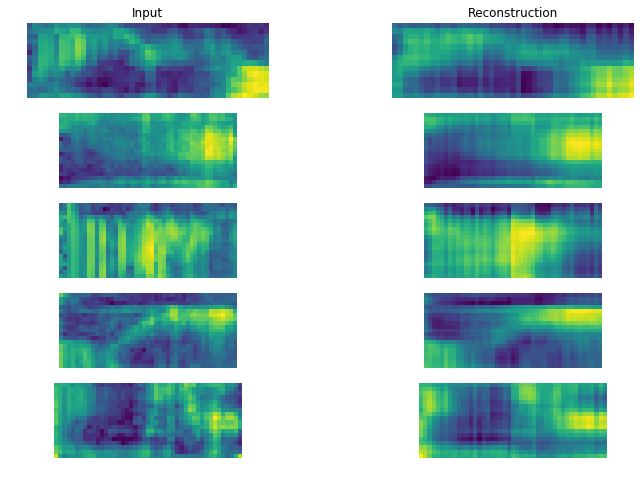

In [40]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]])
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]])
    plt.axis("off")